In [66]:
%matplotlib inline

import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests 
import io
import json
import json
import urllib.parse
from urllib.parse import quote
import datetime
import zipfile
import csv
import math
from datetime import timedelta
import psycopg2
import geopandas
import sqlite3
import copy


In [82]:
debug = 0

In [83]:
def lcm_mult(a):
    if len(a) < 2:
        raise Exception("pass at laest two")
    res = lcm(a[0],a[1])
    for i in range(2,len(a)):
        res = lcm(res,a[i])
    return res
        
        
def lcm(a, b):
    return abs(a*b) // math.gcd(a, b)

In [86]:
class Schedule:
    
    def compute_overlap_period_day(self,lower,upper,mydate):
        # check if candidate schedule is possible on the date
        if mydate.month < self.month_from or mydate.month > self.month_to:
            return None
        if mydate.weekday()+1 < self.week_from or mydate.weekday()+1 > self.week_to:
            return None

        # check if candidate schedule overlaps with period 
        cand_lower = datetime.datetime(mydate.year,mydate.month,mydate.day, self.hour_from, self.min_from )
        cand_upper = datetime.datetime(mydate.year,mydate.month,mydate.day, self.hour_to, self.min_to )

        max_lower = max( cand_lower, lower )
        min_upper = min( cand_upper, upper )

        if max_lower <= min_upper: # overlap 
            return {'from' : max_lower , 'to' : min_upper , 'interval' : self.interval }
        else:
            return None
    
    def compute_overlap_periods(self,lower,upper):
        if debug:
            print("computing overlap between schedule and period: l:{}, u:{}, month from:{} month to:{} ".format(lower,upper,self.month_from,self.month_to))
        
        # compute candidate schedules
        schedules = []
        if not self.international or self.status != 1 : # not international or not operational
            return schedules
        
        if lower.date() == upper.date() : # period is on same day
            mydate = lower.date()
            
            s = self.compute_overlap_period_day(lower,upper,mydate)
            if s:             
                schedules.append( s )
            
        else: # critical period as it overlaps two days
            
            left_period = self.compute_overlap_period_day(lower,upper,lower.date())
            right_period = self.compute_overlap_period_day(lower,upper,upper.date())
            
            if left_period and right_period : # check if valid in both periods. If yes, construct a single period
                if left_period['to'] + datetime.timedelta(minutes=1) == right_period['from']: #continuous
                    s = {'from'  : left_period['from']  , 'to' : right_period['to'] , 'interval' : right_period['interval'] }
                    schedules.append(  s   )
                else: # not continous, need both with gap
                    schedules += [ left_period, right_period ]                    
            elif left_period : # but not right
                schedules.append( left_period )
            elif right_period : # but not left
                schedules.append( right_period )
        if debug:
            print("result: {}".format(schedules))
        return schedules
    
    def generate_and_count(overlap_periods):
        if debug:
            print("gen_count: {}".format(overlap_periods))
        
        observations = []
        for op in overlap_periods:
            date_generated = [op['from'] + datetime.timedelta(seconds=x*op['interval']) for x in 
                              range(0, math.ceil((op['to']-op['from']).total_seconds() /  op['interval'] ))  ]
            observations += date_generated
            if debug:
                print("obs:{}".format(date_generated))
        
        
        return len( set(observations) )
        
        
        #raise Exception("non trivial overlapping schedules not yet implemented")
     
    # here we detect schedules where the from is higher than the to, which can sometimes happen 
    # when the schedule goes into the next day
    # in this case we split the schedule into two parts
    def pre_process_weird_schedules(schedules):
        ret = []
        
        change = False
        
        for s in schedules:
            
            if s.hour_from >= s.hour_to or ( s.hour_from == s.hour_to and s.min_from > s.min_to  ): # if the schedule is weird
                
                if s.month_from + s.month_to != 13 or s.week_from + s.week_to != 8:
                    print("error: schedule invalid. {}".format(s))
                    continue
                
                # we split the schedule into two equivalent schedules having from < to                
                change = True
                
                s1 = copy.copy( s )
                s2 = copy.copy( s )
                
                s1.hour_to = 23
                s1.min_to = 59
                
                s2.hour_from = 0
                s2.min_from = 0
                
                ret.append(s1)
                ret.append(s2)
                                
            else:
                ret.append( s )
         
        if change and debug:
            print("process weird schedules: {}".format( [ str(s) for s in ret] ))

        return ret
                
            
    
    
    def number_expected(schedules,lower,upper):
        if debug:
            print("computing nr exp:  lower:{}, upper:{} , schedules: {} ".format(lower,upper,",".join( [ str(s) for s in schedules]  )))
        
        schedules = Schedule.pre_process_weird_schedules(schedules) 
        
        if debug:
            print("computing nr exp:  lower:{}, upper:{} , schedules: {} ".format(lower,upper,",".join( [ str(s) for s in schedules]  )))
        
        
        periods = []
        for s in schedules:
            periods += s.compute_overlap_periods(lower,upper)
        
        if debug:
            print("step 1: overlap periods: {}".format(periods))
        # check if periods overlap
        overlap = [False] * len(periods)
        for i in range(0,len(periods)):
            for j in range(i+1,len(periods)):
                if min(periods[i]['to'],periods[j]['to'])  >=  max(periods[j]['from'], periods[i]['from']):
                    overlap[i] = True
                    overlap[j] = True
                    break
        if debug:
            print("overlap: {}".format(overlap))        
        # calculate number observations 
        ret = 0
        i = 0
        overlap_periods = []
        for p in periods:
            if not overlap[i]:
                # we need ceil because the interval between from and to can be shorter than the reporting inteval
                # but it still counts as one observation
                r_temp = math.ceil((p['to'] - p['from']).total_seconds() / p['interval']) 
                ret += r_temp
                if debug:
                    print("from: {from} to: {to} int: {interval}. res: {}".format(r_temp,**p))
                    #print(ret)
            else:
                overlap_periods.append(p)
            i+=1
        
        if len(overlap_periods) > 0:
            
            if lower.date() == upper.date() :
                overlap_periods_wrapper = [ overlap_periods , ]
            else: #can consider periods on one day separately from the ones on the other day
                temp={}
                temp[lower.date()] = []
                temp[upper.date()] = []
                
                for op in overlap_periods:
                    temp[op['from'].date()].append(op) #group by date
            
                overlap_periods_wrapper = [ temp[upper.date()] , temp[lower.date()] ]
            
            for overlap_periods in overlap_periods_wrapper:
            
                # observations in periods with overlap
                # first get "overlap-points"
                overlap_points = []
                for op in overlap_periods:
                    overlap_points += [ op['from'] , op['to'] ]

                overlap_points = list(set(overlap_points)) # get unique set of overlap points
                if len(overlap_points) == 2 : #
                    # depending on how many schedules we have we can use our equations or need to compute
                    if len(overlap_periods) == 2:
                        if debug:
                            print("step 2 with 2")
                        start_a = overlap_periods[0]['from']
                        end_a = overlap_periods[0]['to']
                        start_b = overlap_periods[1]['from']
                        end_b = overlap_periods[1]['to']
                        freq_a = overlap_periods[0]['interval'] 
                        freq_b = overlap_periods[1]['interval']

                        nr_a = (end_a - start_a).total_seconds()  / freq_a
                        nr_b = (end_b - start_b).total_seconds() / freq_b

                        nr_dupes = (end_a - start_a).total_seconds() / lcm(freq_a,freq_b)
                        if debug:
                            print("nr_a: {} , nr_b: {} , freq_a:{} , freq_b:{}".format(nr_a,nr_b,freq_a,freq_b))

                        ret += nr_a+nr_b-nr_dupes

                    elif len(overlap_periods) == 3:
                        if debug:
                            print("step 2 with 3")
                        start_a = overlap_periods[0]['from']
                        end_a = overlap_periods[0]['to']
                        start_b = overlap_periods[1]['from']
                        end_b = overlap_periods[1]['to']
                        start_c = overlap_periods[2]['from']
                        end_c = overlap_periods[2]['to']

                        freq_a = overlap_periods[0]['interval'] 
                        freq_b = overlap_periods[1]['interval']
                        freq_c = overlap_periods[2]['interval']

                        nr_a = (end_a - start_a).total_seconds()  / freq_a
                        nr_b = (end_b - start_b).total_seconds() / freq_b
                        nr_c = (end_c - start_c).total_seconds() / freq_c

                        nr_dupes_ab = (end_a - start_a).total_seconds() / lcm(freq_a,freq_b)
                        nr_dupes_ac = (end_a - start_a).total_seconds() / lcm(freq_a,freq_c)
                        nr_dupes_bc = (end_a - start_a).total_seconds() / lcm(freq_b,freq_c)

                        nr_dupes_abc = (end_a - start_a).total_seconds() / lcm_mult([freq_a,freq_b,freq_c])

                        ret +=  (nr_a + nr_b + nr_c) - (nr_dupes_ab + nr_dupes_ac + nr_dupes_bc) + nr_dupes_abc

                    else: # we generate points, de-duplicate them and count 
                        ret += Schedule.generate_and_count(overlap_periods)

                else:
                    # we generate points, de-duplicate them and count
                    ret += Schedule.generate_and_count(overlap_periods)
        
        ret = math.floor(ret)
        if debug:
            print("ret {}".format(ret))
        return ret
    
       
    
    def create_default_schedule():
        
        s = Schedule()
        
        s.month_from = 1
        s.month_to = 12
        s.week_from = 1
        s.week_to = 7
        s.hour_from = 0
        s.hour_to = 23
        s.min_from = 0
        s.min_to = 59
        s.interval = 60*60*6 #6 hourly
        s.international = True
        s.status = 1
        
        return s
    
    def __str__(self):
        return "from {month_from}/{week_from} {hour_from}:{min_from}  to: {month_to}/{week_to} {hour_to}:{min_to} interval: {interval}".format(**self.__dict__)
    
    
    def __init__(self,row=None):
        
        if row:
            self.status = int(row['OPERATING_STATUS_DECLARED_ID'])
            try: 
                self.month_from = int(row['MONTH_SINCE_NU'])
                self.month_to = int(row['MONTH_TILL_NU'])
            except ValueError :
                self.month_from = 1
                self.month_to = 12
            try:
                self.week_from = int(row['WEEKDAY_SINCE_NU']) 
                self.week_to = int(row['WEEKDAY_TILL_NU'])
            except ValueError :
                self.week_from = 1
                self.week_to = 7
            try:
                self.hour_from = int(row['HOUR_SINCE_NU'])
                self.hour_to = int(row['HOUR_TILL_NU'])
            except ValueError :
                self.hour_from = 0
                self.hour_to = 23
            try:    
                self.min_from = int(row['MINUTE_SINCE_NU'])
                self.min_to = int(row['MINUTE_TILL_NU'])
            except ValueError :
                self.min_from = 0
                self.min_to = 59
            try:
                self.interval = int(row['TEMP_REP_INTERVAL_NU'])
            except ValueError :
                self.interval = 60*60*6 #6h

            self.international = True
 

In [87]:
# tests
year = 2019
month = 3
day = 25 
hour = 0

mydate = datetime.datetime(year, month, day,hour)

lower_boundary = mydate - timedelta(hours=3)
upper_boundary = mydate + timedelta(hours=3)

s = Schedule.create_default_schedule() # default schedule has 6h observations

r = Schedule.number_expected([s],lower_boundary,upper_boundary)
expected = 1

print("test 1: {} equals {} {} ".format(r,expected,r==expected))

#print(s.compute_overlap_periods(lower_boundary,upper_boundary))

#mydate = datetime.datetime(year, month, day,hour)

#lower_boundary = mydate - timedelta(hours=3)
#upper_boundary = mydate + timedelta(hours=3)

#print(s.compute_overlap_periods(lower_boundary,upper_boundary))

# test nr 2

s1 = Schedule.create_default_schedule()
s1.hour_from = 0
s1.min_from = 30
s1.hour_to = 23
s1.min_to = 30
s1.interval = 60*30

s2 = Schedule.create_default_schedule()
s2.hour_from = 0
s2.min_from = 30
s2.hour_to = 23
s2.min_to = 30
s2.interval = 60*60

s3 = Schedule.create_default_schedule()
s3.hour_from = 22
s3.min_from = 0
s3.hour_to = 23
s3.min_to = 30
s3.interval = 60*5


r = Schedule.number_expected([s1,s2,s3],lower_boundary,upper_boundary)
expected = 25
print("test 2: {} equals {} {} ".format(r,expected,r==expected))



# test 3: 30 min vs 45min overlap test

s4 = Schedule.create_default_schedule()
s4.interval = 60*30

s5 = Schedule.create_default_schedule()
s5.interval = 60*45

r = Schedule.number_expected([s4,s5],lower_boundary,upper_boundary)
expected = 16

print("test 3: {} equals {} {} ".format(r,expected,r==expected))


# test 4: bug identified by ECMWF 

s6 = Schedule.create_default_schedule()
s6.hour_from = 0
s6.min_from = 0
s6.hour_to = 12
s6.min_to = 59
s6.interval = 3*60*60

s7 = Schedule.create_default_schedule()
s7.hour_from = 18
s7.min_from = 0
s7.hour_to = 21
s7.min_to = 59
s7.interval = 3*60*60


r = Schedule.number_expected([s6,s7],lower_boundary,upper_boundary)
expected = 2

print("test 4: {} equals {} {} ".format(r,expected,r==expected))

# test 5 : upper boundary higher than upper boundary (e.g spanish YECLA station)

s = Schedule.create_default_schedule()
s.hour_from = 22
s.min_from = 0
s.hour_to = 21
s.min_to = 59
s.interval = 60*60

r = Schedule.number_expected([s,],lower_boundary,upper_boundary)
expected = 6

print("test 5: {} equals {} {} ".format(r,expected,r==expected))



test 1: 1 equals 1 True 
test 2: 25 equals 25 True 
test 3: 16 equals 16 True 
test 4: 2 equals 2 True 
test 5: 6 equals 6 True 


In [88]:
# quote URL parameters, OSCAR/Surface style
def oscarQuote(params):
    ret=[]
    for key, value in params.items():
        if isinstance(value,list):
            mykey = urllib.parse.quote(key)
            values = [urllib.parse.quote(v) for v in value]
            myvalue = ",".join(values)
        else:
            mykey=urllib.parse.quote(key)
            myvalue=urllib.parse.quote(value)
            
        ret.append("{}={}".format(mykey,myvalue))

    return "&".join(ret)
    

In [7]:
_cache_stations = None
_cache_schedules = None

def computeExpected(mydate,cache=False):
    
    lower = mydate - datetime.timedelta(hours=3)
    upper = mydate + datetime.timedelta(hours=3)
    # get OSCAR stations measuring surface pressure
    params = {
        'variable' : "216",
        'facilityType' : ['seaFixed','airFixed','seaFixed','seaMobile','lakeRiverFixed','lakeRiverMobile','landFixed','landMobile','landOnIce']
    }

    param = oscarQuote(params)

    url = "https://oscar.wmo.int/surface/rest/api/search/station?{}".format(param)
    #url = "https://oscardepl.wmo.int/surface/rest/api/search/station?{}".format(param)

    global _cache_stations
    if cache and _cache_stations:
        r = _cache_stations
    else:
        r = requests.get(url)
        if cache:
            _cache_stations = r

    
    oscar_stations = [ [i['wigosStationIdentifier'],s['name'],s['latitude'],s['longitude']] for s in r.json() for i in s['wigosStationIdentifiers'] if i['primary'] ]
    oscar_station_map = {}
    for s in oscar_stations:
        oscar_station_map[s[0]]=[s[1],s[2],s[3]]

        
    today = mydate.strftime("%Y%m%d")

    #oscar_schedules_file = "https://oscar.wmo.int/oscar/wdqms/surface_pressure_schedules_report-{}.zip".format(today)
    oscar_schedules_file = "https://oscardepl.wmo.int/oscar/wdqms/surface_pressure_schedules_report-{}.zip".format(today)

    global _cache_schedules
    if cache and _cache_schedules:
        r = _cache_schedules
    else:
        r = requests.get(oscar_schedules_file)
        if cache:
            _cache_schedules = r

    
    # STATION_NAME_TX	WMO_INDEX_TX	ISO3_COUNTRY_CD	PROGRAM_NAME_TX	OPERATING_STATUS_DECLARED_ID	
    # MONTH_SINCE_NU	MONTH_TILL_NU	WEEKDAY_SINCE_NU	WEEKDAY_TILL_NU	HOUR_SINCE_NU	HOUR_TILL_NU	
    # MINUTE_SINCE_NU	MINUTE_TILL_NU	SAMPL_TIME_PERIOD_NU	TMP_SAMPL_INTVL_NU	AGGREG_INTERVAL_NU	
    # TEMP_REP_INTERVAL_NU	TEMP_REP_INTERVAL_TIMESTAMP_ID	INTERNATIONAL_EXCHANGE_YN	DIURNAL_BASE_HOUR_NU	
    # DIURNAL_BASE_MINUTE_NU
    output = io.BytesIO()
    output.write(r.content)
    station_schedules = {}
    with zipfile.ZipFile(output) as zfile:
         with zfile.open(zfile.infolist()[0]) as myfile:
            with io.TextIOWrapper(myfile,encoding='utf-8') as wrapper:
                reader = csv.DictReader(wrapper,delimiter='\t')
                for row in reader:
                    wigos_id = row['WMO_INDEX_TX']
                    if not wigos_id in station_schedules:
                        station_schedules[wigos_id] = []              
                    station_schedules[wigos_id].append( Schedule(row) ) 


    for wigos_id in oscar_station_map:
        if not wigos_id in station_schedules:
            #print("assigning default schedule to {}".format(wigos_id))
            station_schedules[wigos_id] = [ Schedule.create_default_schedule() , ]
            
            
            
    c=0
    result = {}
    for wigos_id,schedules in station_schedules.items():
        #if c>1:
        #    break
        c+=1
        nr_ex = Schedule.number_expected( schedules, lower, upper )
        #log = "{}, {} ".format(wigos_id,nr_ex)
        if wigos_id in oscar_station_map :
            result[wigos_id] = { 'nr' : nr_ex , 
                                'lat' : oscar_station_map[wigos_id][1] , 
                                'lng' :  oscar_station_map[wigos_id][2] }

        
        #f.write( log + "\n" )
        #print(log)
    return result

In [8]:
 

def getNumberReceived(mydate,center='ECMWF'):
    conn = psycopg2.connect("host=127.0.0.1 port=5433 dbname=wdqms user=wdqms password=wdqms")
    cur = conn.cursor()
    sql = """SELECT wigosid,n.indexnbr,lat,lon,nr_received FROM nwpdatabyperiod n JOIN vola v ON (n.vola_id = v.id) 
    WHERE varid = %(varid)s AND yyyy=%(year)s AND mm=%(month)s AND dd=%(day)s AND hourperiod = %(period)s 
    AND CENTER=%(center)s """

    params = { 'varid' : 110 , 'year' : mydate.year , 'month' : mydate.month , 'day' : mydate.day ,
             'period' : mydate.hour , 'center' : center }
    
    cur.execute(sql, params )
    
    return cur.fetchall()
    

In [10]:
start = datetime.datetime(2018,1,1,0)
end = datetime.datetime(2018,12,31,23,59)

steps=math.ceil((end-start).total_seconds() / (6 * 60 * 60) )
#steps = 1

periods = [ start + datetime.timedelta(hours=6*x) for x in range(0, steps  )  ]

with sqlite3.connect('schedules.db') as conn:
    
    conn.execute(""" CREATE TABLE IF NOT EXISTS schedules
             (date text, wigosid text, nr integer) """)
            
    for p in reversed(periods): # start with highest date when chaching
        
        print("getting {}..".format(p))
        #stations_nr_received = getNumberReceived(p,'ECMWF')
        res = computeExpected(p,True)
        
        tuples = []
        for wigos_id,info in res.items():
            tuples.append( ( p, wigos_id, info["nr"] ) )
            
        conn.executemany(""" insert into schedules (date,wigosid,nr) values (?,?,?) """, tuples)
        
        
    conn.commit()

getting 2018-12-31 18:00:00..
getting 2018-12-31 12:00:00..
getting 2018-12-31 06:00:00..
getting 2018-12-31 00:00:00..
getting 2018-12-30 18:00:00..
getting 2018-12-30 12:00:00..
getting 2018-12-30 06:00:00..
getting 2018-12-30 00:00:00..
getting 2018-12-29 18:00:00..
getting 2018-12-29 12:00:00..
getting 2018-12-29 06:00:00..
getting 2018-12-29 00:00:00..
getting 2018-12-28 18:00:00..
getting 2018-12-28 12:00:00..
getting 2018-12-28 06:00:00..
getting 2018-12-28 00:00:00..
getting 2018-12-27 18:00:00..
getting 2018-12-27 12:00:00..
getting 2018-12-27 06:00:00..
getting 2018-12-27 00:00:00..
getting 2018-12-26 18:00:00..
getting 2018-12-26 12:00:00..
getting 2018-12-26 06:00:00..
getting 2018-12-26 00:00:00..
getting 2018-12-25 18:00:00..
getting 2018-12-25 12:00:00..
getting 2018-12-25 06:00:00..
getting 2018-12-25 00:00:00..
getting 2018-12-24 18:00:00..
getting 2018-12-24 12:00:00..
getting 2018-12-24 06:00:00..
getting 2018-12-24 00:00:00..
getting 2018-12-23 18:00:00..
getting 20

getting 2018-10-24 06:00:00..
getting 2018-10-24 00:00:00..
getting 2018-10-23 18:00:00..
getting 2018-10-23 12:00:00..
getting 2018-10-23 06:00:00..
getting 2018-10-23 00:00:00..
getting 2018-10-22 18:00:00..
getting 2018-10-22 12:00:00..
getting 2018-10-22 06:00:00..
getting 2018-10-22 00:00:00..
getting 2018-10-21 18:00:00..
getting 2018-10-21 12:00:00..
getting 2018-10-21 06:00:00..
getting 2018-10-21 00:00:00..
getting 2018-10-20 18:00:00..
getting 2018-10-20 12:00:00..
getting 2018-10-20 06:00:00..
getting 2018-10-20 00:00:00..
getting 2018-10-19 18:00:00..
getting 2018-10-19 12:00:00..
getting 2018-10-19 06:00:00..
getting 2018-10-19 00:00:00..
getting 2018-10-18 18:00:00..
getting 2018-10-18 12:00:00..
getting 2018-10-18 06:00:00..
getting 2018-10-18 00:00:00..
getting 2018-10-17 18:00:00..
getting 2018-10-17 12:00:00..
getting 2018-10-17 06:00:00..
getting 2018-10-17 00:00:00..
getting 2018-10-16 18:00:00..
getting 2018-10-16 12:00:00..
getting 2018-10-16 06:00:00..
getting 20

getting 2018-08-16 18:00:00..
getting 2018-08-16 12:00:00..
getting 2018-08-16 06:00:00..
getting 2018-08-16 00:00:00..
getting 2018-08-15 18:00:00..
getting 2018-08-15 12:00:00..
getting 2018-08-15 06:00:00..
getting 2018-08-15 00:00:00..
getting 2018-08-14 18:00:00..
getting 2018-08-14 12:00:00..
getting 2018-08-14 06:00:00..
getting 2018-08-14 00:00:00..
getting 2018-08-13 18:00:00..
getting 2018-08-13 12:00:00..
getting 2018-08-13 06:00:00..
getting 2018-08-13 00:00:00..
getting 2018-08-12 18:00:00..
getting 2018-08-12 12:00:00..
getting 2018-08-12 06:00:00..
getting 2018-08-12 00:00:00..
getting 2018-08-11 18:00:00..
getting 2018-08-11 12:00:00..
getting 2018-08-11 06:00:00..
getting 2018-08-11 00:00:00..
getting 2018-08-10 18:00:00..
getting 2018-08-10 12:00:00..
getting 2018-08-10 06:00:00..
getting 2018-08-10 00:00:00..
getting 2018-08-09 18:00:00..
getting 2018-08-09 12:00:00..
getting 2018-08-09 06:00:00..
getting 2018-08-09 00:00:00..
getting 2018-08-08 18:00:00..
getting 20

getting 2018-06-09 06:00:00..
getting 2018-06-09 00:00:00..
getting 2018-06-08 18:00:00..
getting 2018-06-08 12:00:00..
getting 2018-06-08 06:00:00..
getting 2018-06-08 00:00:00..
getting 2018-06-07 18:00:00..
getting 2018-06-07 12:00:00..
getting 2018-06-07 06:00:00..
getting 2018-06-07 00:00:00..
getting 2018-06-06 18:00:00..
getting 2018-06-06 12:00:00..
getting 2018-06-06 06:00:00..
getting 2018-06-06 00:00:00..
getting 2018-06-05 18:00:00..
getting 2018-06-05 12:00:00..
getting 2018-06-05 06:00:00..
getting 2018-06-05 00:00:00..
getting 2018-06-04 18:00:00..
getting 2018-06-04 12:00:00..
getting 2018-06-04 06:00:00..
getting 2018-06-04 00:00:00..
getting 2018-06-03 18:00:00..
getting 2018-06-03 12:00:00..
getting 2018-06-03 06:00:00..
getting 2018-06-03 00:00:00..
getting 2018-06-02 18:00:00..
getting 2018-06-02 12:00:00..
getting 2018-06-02 06:00:00..
getting 2018-06-02 00:00:00..
getting 2018-06-01 18:00:00..
getting 2018-06-01 12:00:00..
getting 2018-06-01 06:00:00..
getting 20

getting 2018-04-01 18:00:00..
getting 2018-04-01 12:00:00..
getting 2018-04-01 06:00:00..
getting 2018-04-01 00:00:00..
getting 2018-03-31 18:00:00..
getting 2018-03-31 12:00:00..
getting 2018-03-31 06:00:00..
getting 2018-03-31 00:00:00..
getting 2018-03-30 18:00:00..
getting 2018-03-30 12:00:00..
getting 2018-03-30 06:00:00..
getting 2018-03-30 00:00:00..
getting 2018-03-29 18:00:00..
getting 2018-03-29 12:00:00..
getting 2018-03-29 06:00:00..
getting 2018-03-29 00:00:00..
getting 2018-03-28 18:00:00..
getting 2018-03-28 12:00:00..
getting 2018-03-28 06:00:00..
getting 2018-03-28 00:00:00..
getting 2018-03-27 18:00:00..
getting 2018-03-27 12:00:00..
getting 2018-03-27 06:00:00..
getting 2018-03-27 00:00:00..
getting 2018-03-26 18:00:00..
getting 2018-03-26 12:00:00..
getting 2018-03-26 06:00:00..
getting 2018-03-26 00:00:00..
getting 2018-03-25 18:00:00..
getting 2018-03-25 12:00:00..
getting 2018-03-25 06:00:00..
getting 2018-03-25 00:00:00..
getting 2018-03-24 18:00:00..
getting 20

getting 2018-01-23 06:00:00..
getting 2018-01-23 00:00:00..
getting 2018-01-22 18:00:00..
getting 2018-01-22 12:00:00..
getting 2018-01-22 06:00:00..
getting 2018-01-22 00:00:00..
getting 2018-01-21 18:00:00..
getting 2018-01-21 12:00:00..
getting 2018-01-21 06:00:00..
getting 2018-01-21 00:00:00..
getting 2018-01-20 18:00:00..
getting 2018-01-20 12:00:00..
getting 2018-01-20 06:00:00..
getting 2018-01-20 00:00:00..
getting 2018-01-19 18:00:00..
getting 2018-01-19 12:00:00..
getting 2018-01-19 06:00:00..
getting 2018-01-19 00:00:00..
getting 2018-01-18 18:00:00..
getting 2018-01-18 12:00:00..
getting 2018-01-18 06:00:00..
getting 2018-01-18 00:00:00..
getting 2018-01-17 18:00:00..
getting 2018-01-17 12:00:00..
getting 2018-01-17 06:00:00..
getting 2018-01-17 00:00:00..
getting 2018-01-16 18:00:00..
getting 2018-01-16 12:00:00..
getting 2018-01-16 06:00:00..
getting 2018-01-16 00:00:00..
getting 2018-01-15 18:00:00..
getting 2018-01-15 12:00:00..
getting 2018-01-15 06:00:00..
getting 20

In [11]:
conn.close()

In [ ]:
conn = sqlite3.connect("schedules.db")
df_schedules = pd.read_sql_query("select * from schedules",conn)
conn.close()

In [35]:
df_schedules

,date,wigosid,nr
0,2019-05-27 18:00:00,0-20008-0-WHI,1
1,2019-05-27 18:00:00,0-20008-0-KOS,2
2,2019-05-27 18:00:00,0-20008-0-DON,6
3,2019-05-27 18:00:00,0-20008-0-IRE,6
4,2019-05-27 18:00:00,0-20008-0-NGL,6
5,2019-05-27 18:00:00,0-20008-0-NMY,36
6,2019-05-27 18:00:00,0-20008-0-ALT,72
7,2019-05-27 18:00:00,0-20008-0-SMO,6
8,2019-05-27 18:00:00,0-20008-0-PSU,360
9,2019-05-27 18:00:00,0-20008-0-FPE,360


In [9]:
myperiod = datetime.datetime(2019,5,15,0)

expected = computeExpected(myperiod)
received = getNumberReceived(myperiod)


In [10]:
df_exp = pd.DataFrame.from_dict(expected,orient='index').rename(columns={'nr':'expected'})
df_rec = pd.DataFrame(received).set_index(0).rename(columns={1:'indexnbr',4:'received',3:'longitude',2:'latitude'})

In [92]:
df_available = df_exp.join(df_rec,how='inner').drop(['latitude','longitude'],axis=1)
df_empty = df_exp.join(df_rec,how='left')
df_empty = df_empty[  df_empty['received'].isnull() ].drop(['indexnbr','latitude','longitude','received'],axis=1)

# remove from empty those where we did not expect a report
df_empty = df_empty[df_empty['expected']>0]


In [93]:
df_unknown = df_rec.join(df_exp,how='left')
df_unknown = df_unknown[ df_unknown['expected'].isnull() ].drop(['expected','lat','lng'],axis=1)

df_unknown['latitude']= df_unknown['latitude'].apply( lambda x : float(x.split(',')[0])  )
df_unknown['longitude']= df_unknown['longitude'].apply( lambda x : float(x.split(',')[0])  )


In [94]:
df_available['percentage'] = df_available['received'] / df_available['expected']
df_available['status'] = np.where( df_available['percentage'] == np.inf , 'pink' , 
                    np.where( df_available['percentage'] < 0.3 , 'red', 
                         np.where( df_available['percentage'] < 0.8 , 'orange' , 'green')))


In [95]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

gdf_available = geopandas.GeoDataFrame(
    df_available, geometry=geopandas.points_from_xy(df_available.lng, df_available.lat))

gdf_empty = geopandas.GeoDataFrame(
    df_empty, geometry=geopandas.points_from_xy(df_empty.lng, df_empty.lat))

gdf_unknown = geopandas.GeoDataFrame(
    df_unknown, geometry=geopandas.points_from_xy(df_unknown.longitude, df_unknown.latitude))




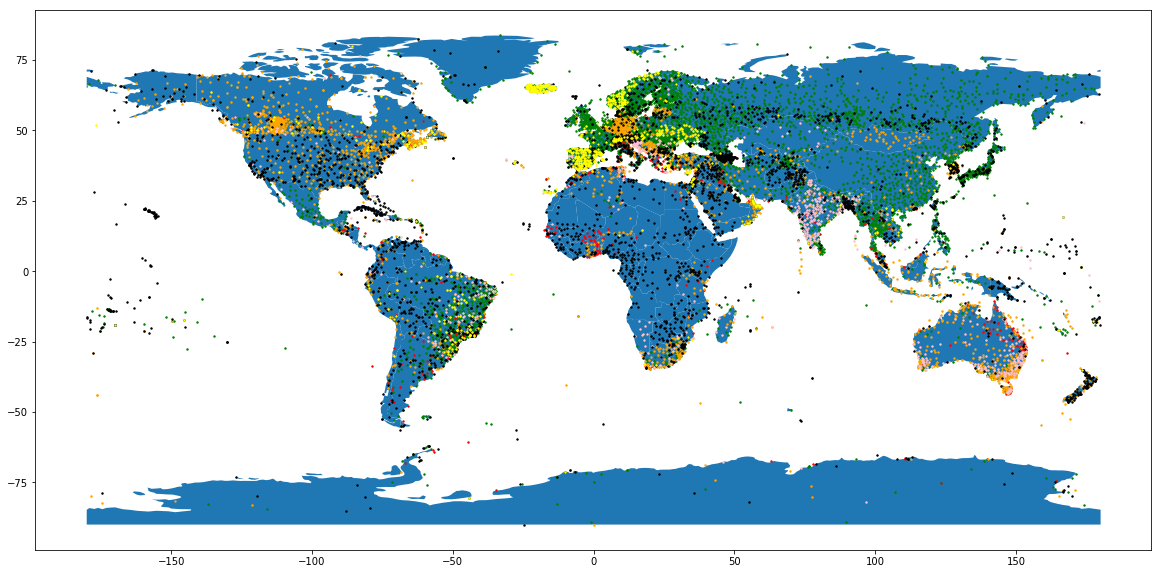

In [99]:
ax=world.plot(figsize=(20,20))
for color in ['green','red','orange','pink']:
    gdf_available[ gdf_available['status'] == color ].plot(ax=ax,color=color,markersize=2)
gdf_empty.plot(ax=ax,color='black',markersize=2)
gdf_unknown.plot(ax=ax,color='yellow',markersize=2)


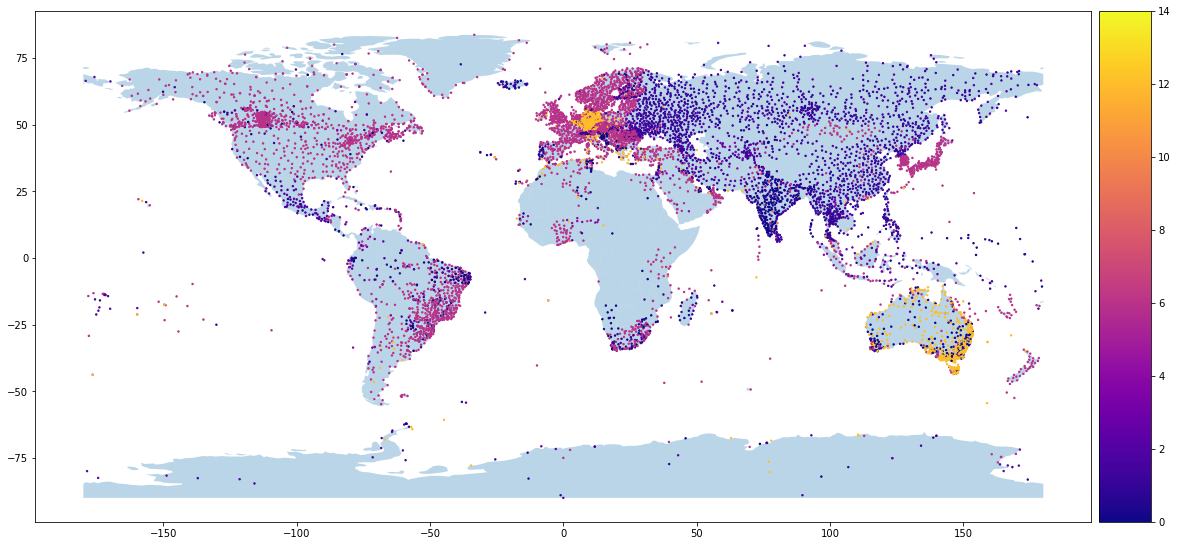

In [119]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1 , figsize=(20,20) )
divider = make_axes_locatable(ax)    
cax = divider.append_axes("right", size="5%", pad=0.1)

ax=world.plot(figsize=(20,20),ax=ax,cax=cax,alpha=0.3)
gdf_available.plot(ax=ax,column='expected',legend=True,cmap='plasma',cax=cax,markersize=2)



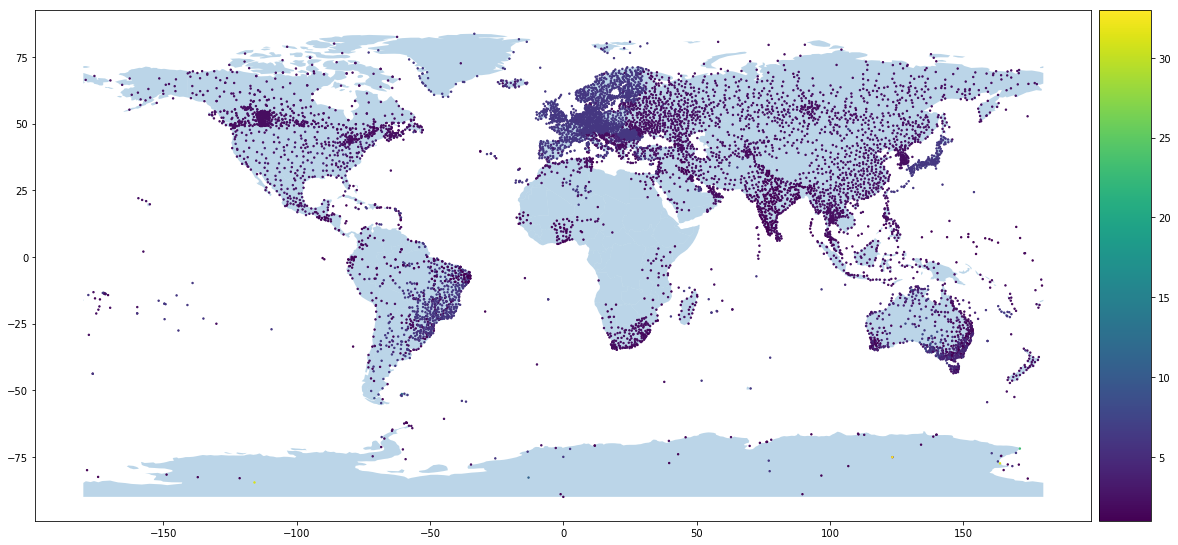

In [121]:
fig, ax = plt.subplots(1, 1 , figsize=(20,20) )
divider = make_axes_locatable(ax)    
cax = divider.append_axes("right", size="5%", pad=0.1)

ax=world.plot(figsize=(20,20),ax=ax,cax=cax,alpha=0.3)
gdf_available.plot(ax=ax,column='received',legend=True,cax=cax,markersize=2)
